# Assignment 2 - Pneumonia Detection

Name: <b>Chirag Shah</b>  & <b>Kunal Tolani</b><br>
Student ID: <b>19200072</b> & <b>19200153</b>



## Imports

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import RMSprop, adam
from keras import backend as K
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.wrappers.scikit_learn import KerasClassifier


import sklearn
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression

from IPython.display import SVG

import csv
import os 
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import scipy as sp
import PIL

## Task 1: Load pneumonia data from *kaggle* & preprocessing

Data was loaded on kaggle and imported to Google Colab. This was performed because data on Colab was lost in case of network unavailability.
Also, another option was to upload data to Google drive and read, but we observed that the speed of read operation from Google drive was very slow.

To successfully load the dataset, the command `files.upload()` requires kaggle.json config file to be uploaded. This file is available in the zip file of the solution.

### Load Data

**Warning: This will download entire dataset from kaggle**

In [0]:
! pip install -q kaggle
#from google.colab import files
#files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d kunal4/pneumonia
! unzip pneumonia.zip -d pneumonia

### Divide data into train and test & set configurations for images

In [0]:
# location of data
dataset_name = 'pneumonia/chest_xray'

# train and test data directories
train_data_dir = dataset_name + '/train/'

test_data_dir = dataset_name + '/test/'

# Data sample rate - using the entire data
sample_rate = 1.0

# Image dimensions - 162 x 128
img_width, img_height = 162, 128

# different orderding of channels according to models.
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

### Process images from train directory (Read, resize and normalize)

In [7]:
training_class_folders = [i for i in os.listdir(train_data_dir) if not i.startswith('.')] # use this for full dataset
num_classes = len(training_class_folders)

# Initialise arrays for data storage
X_train = np.ndarray((0, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
y_train = np.ndarray(0, dtype=np.str)
    
# Loop through the class folders
for i, image_cls in enumerate(training_class_folders):
    
    print('Processing class {}'.format(image_cls))
    image_class_folder = train_data_dir + image_cls + "/"

    # generate filenames from the data folder and do sampling
    image_filenames = [image_class_folder+i for i in os.listdir(image_class_folder) if not i.startswith('.')] # use this for full dataset
    image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

    # Create a data array for image data
    count = len(image_filenames)
    X_train_part = np.ndarray((count, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)

    # Iterate throuigh the filenames and for each one load the image, resize and normalise
    for i, image_file in enumerate(image_filenames):

        # Low the images and resize them
        image = cv2.imread(image_file, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
        image = image[:,:,[2,1,0]] # OpenCV and matplotlib use differnet channel oerderings so fix this
        
        # If channel order of network does not match open cv format swap it
        if K.image_data_format() == 'channels_first':
            image=np.swapaxes(np.swapaxes(image, 1, 2), 0, 1)
            
        # Add image data to data array and normalise
        X_train_part[i] = image
        X_train_part[i] = X_train_part[i]/255
        
        # Add label to label array
        y_train = np.append(y_train, image_cls)
        
        if i%100 == 0: print('Processed {} of {} for class {} '.format(i, count, image_cls))

    print('Processed {} of {} for class {} '.format(i + 1, count, image_cls))
    
    # Append the part to the overall data array
    X_train = np.append(X_train, X_train_part, axis=0)
    
print("Data shape: {}".format(X_train.shape))

Processing class PNEUMONIA
Processed 0 of 3883 for class PNEUMONIA 
Processed 100 of 3883 for class PNEUMONIA 
Processed 200 of 3883 for class PNEUMONIA 
Processed 300 of 3883 for class PNEUMONIA 
Processed 400 of 3883 for class PNEUMONIA 
Processed 500 of 3883 for class PNEUMONIA 
Processed 600 of 3883 for class PNEUMONIA 
Processed 700 of 3883 for class PNEUMONIA 
Processed 800 of 3883 for class PNEUMONIA 
Processed 900 of 3883 for class PNEUMONIA 
Processed 1000 of 3883 for class PNEUMONIA 
Processed 1100 of 3883 for class PNEUMONIA 
Processed 1200 of 3883 for class PNEUMONIA 
Processed 1300 of 3883 for class PNEUMONIA 
Processed 1400 of 3883 for class PNEUMONIA 
Processed 1500 of 3883 for class PNEUMONIA 
Processed 1600 of 3883 for class PNEUMONIA 
Processed 1700 of 3883 for class PNEUMONIA 
Processed 1800 of 3883 for class PNEUMONIA 
Processed 1900 of 3883 for class PNEUMONIA 
Processed 2000 of 3883 for class PNEUMONIA 
Processed 2100 of 3883 for class PNEUMONIA 
Processed 2200 of

### Process images from test directory (Read, resize and normalize)

In [8]:
testing_class_folders = [i for i in os.listdir(test_data_dir) if not i.startswith('.')] # use this for full dataset
num_classes = len(testing_class_folders)

# Initialise arrays for data storage
X_test_data = np.ndarray((0, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
y_test_data = np.ndarray(0, dtype=np.str)
    
# Loop through the class folders
for i, image_cls in enumerate(testing_class_folders):
    
    print('Processing class {}'.format(image_cls))
    image_class_folder = test_data_dir + image_cls + "/"

    # generate filenames from the data folder and do sampling
    image_filenames = [image_class_folder+i for i in os.listdir(image_class_folder) if not i.startswith('.')] # use this for full dataset
    image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

    # Create a data array for image data
    count = len(image_filenames)
    X_test_part = np.ndarray((count, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)

    # Iterate throuigh the filenames and for each one load the image, resize and normalise
    for i, image_file in enumerate(image_filenames):

        # Low the images and resize them
        image = cv2.imread(image_file, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
        image = image[:,:,[2,1,0]] # OpenCV and matplotlib use differnet channel oerderings so fix this
        
        # If channel order of network does not match open cv format swap it
        if K.image_data_format() == 'channels_first':
            image=np.swapaxes(np.swapaxes(image, 1, 2), 0, 1)
            
        # Add image data to data array and normalise
        X_test_part[i] = image
        X_test_part[i] = X_test_part[i]/255
        
        # Add label to label array
        y_test_data = np.append(y_test_data, image_cls)
        
        if i%100 == 0: print('Processed {} of {} for class {} '.format(i, count, image_cls))

    print('Processed {} of {} for class {} '.format(i + 1, count, image_cls))
    
    # Append the part to the overall data array
    X_test_data = np.append(X_test_data, X_test_part, axis=0)
    
print("Data shape: {}".format(X_test_data.shape))

Processing class PNEUMONIA
Processed 0 of 390 for class PNEUMONIA 
Processed 100 of 390 for class PNEUMONIA 
Processed 200 of 390 for class PNEUMONIA 
Processed 300 of 390 for class PNEUMONIA 
Processed 390 of 390 for class PNEUMONIA 
Processing class NORMAL
Processed 0 of 234 for class NORMAL 
Processed 100 of 234 for class NORMAL 
Processed 200 of 234 for class NORMAL 
Processed 234 of 234 for class NORMAL 
Data shape: (624, 162, 128, 3)


### Split into train and validation set

In [0]:
# Perfrom split to train, validation, test
X_train_data, X_val_data, y_train_data, y_val_data = train_test_split(X_train, y_train, random_state=0, test_size = 0.3, train_size = 0.7, shuffle=True)

### Perform label encoding to convert class vectors to binary classes.

In [0]:
# Convert class vectors to binary class matrices.
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train_data)
y_train_wide = keras.utils.to_categorical(y_train_num, num_classes)

y_test_num = y_train_encoder.fit_transform(y_test_data)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)

y_val_num = y_train_encoder.fit_transform(y_val_data)
y_val_wide = keras.utils.to_categorical(y_val_num, num_classes)

In [11]:
#Mapping labels to binary classes
classes_num_label = dict()

for idx, lbl in enumerate(y_train_encoder.classes_):
    classes_num_label[idx] = lbl
classes_num_label

{0: 'NORMAL', 1: 'PNEUMONIA'}

### Display random images

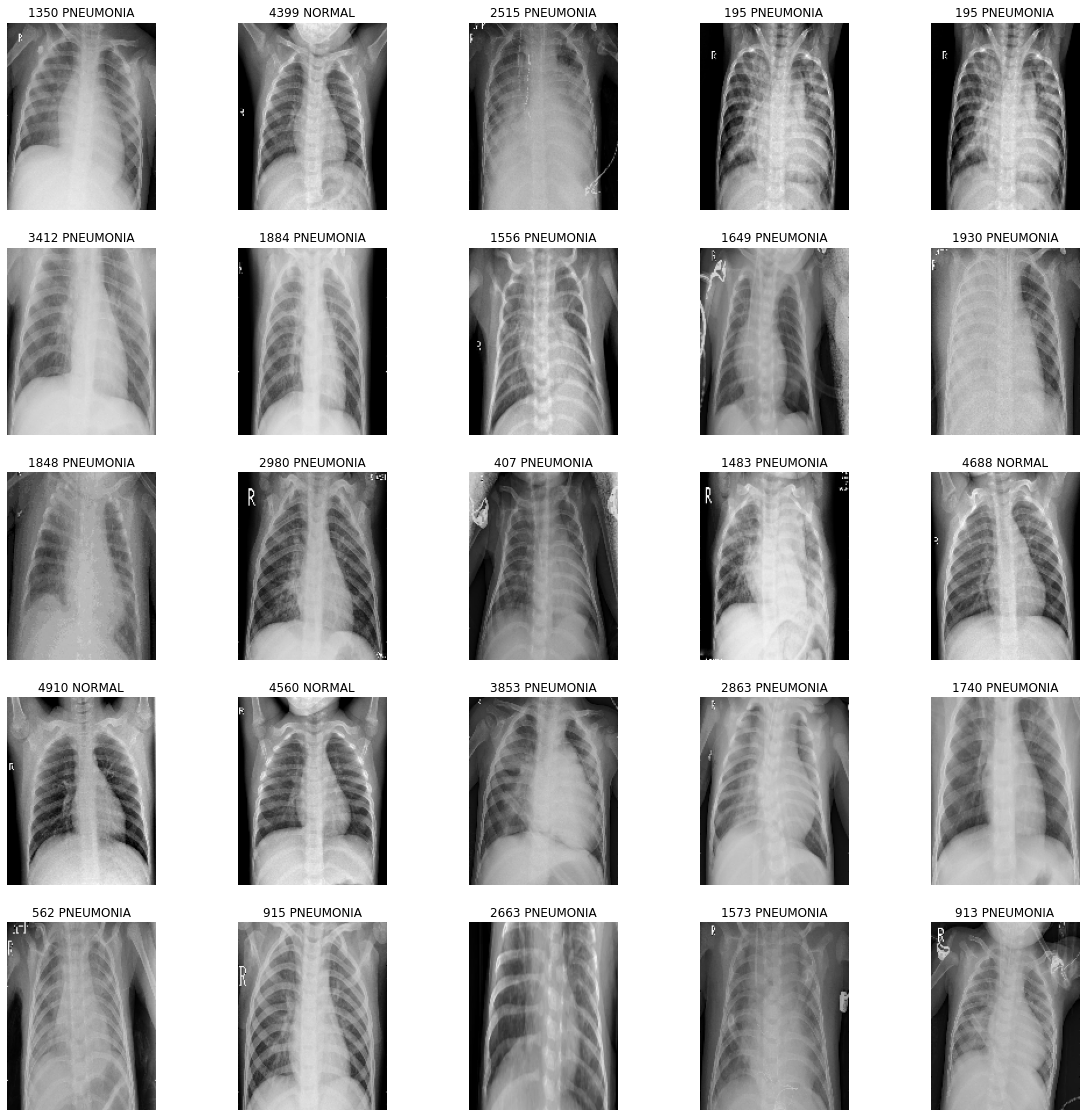

In [12]:
pltsize=4
row_images = 5
col_images = 5
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(row_images * col_images):
    i_rand = random.randint(0, X_train.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow(PIL.Image.fromarray((X_train[i_rand] * 255).astype(np.uint8)))
    plt.title((str(i_rand) + " " + y_train[i_rand]))

### Reshape / flatten data for logistic regression

In [0]:
#Flatten data for use in Logistic Regression
X_train_flat = X_train_data.reshape(X_train_data.shape[0], X_train_data.shape[1]*X_train_data.shape[2]*X_train_data.shape[3])

X_test_flat = X_test_data.reshape(X_test_data.shape[0], X_test_data.shape[1]*X_test_data.shape[2]*X_test_data.shape[3])

X_val_flat = X_val_data.reshape(X_val_data.shape[0], X_val_data.shape[1]*X_val_data.shape[2]*X_val_data.shape[3])

## Task 2: Logistic Regression

In [14]:
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_flat,y_train_data)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Evaluation & Classification report on training set

In [15]:
train_acc = {}

y_pred_lr = log_reg.predict(X_train_flat)
print(metrics.classification_report(y_train_data, y_pred_lr))
print("Confusion matrix")
print(metrics.confusion_matrix(y_train_data, y_pred_lr))
train_acc['Logistic Regression'] = metrics.accuracy_score(y_train_data, y_pred_lr)

              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00       908
   PNEUMONIA       1.00      1.00      1.00      2754

    accuracy                           1.00      3662
   macro avg       1.00      1.00      1.00      3662
weighted avg       1.00      1.00      1.00      3662

Confusion matrix
[[ 908    0]
 [   0 2754]]


### Evaluation and Classifciation report on test set

In [16]:
test_acc = {}

y_pred_lr_test = log_reg.predict(X_test_flat)
print(metrics.classification_report(y_test_data, y_pred_lr_test))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_data, y_pred_lr_test))

test_acc['Logistic Regression'] = metrics.accuracy_score(y_test_data, y_pred_lr_test)

              precision    recall  f1-score   support

      NORMAL       0.96      0.32      0.49       234
   PNEUMONIA       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.84      0.66      0.66       624
weighted avg       0.80      0.74      0.70       624

Confusion matrix
[[ 76 158]
 [  3 387]]


### Inference

As a simple base model, we used Logistic Regression with the default parameters, with only a large number of maximum iterations to allow the model to converge. 

The results on test set were fine - especially a recall score of 0.98 in pneumonia patients. There are a large number of false positives but this is expected from a base classifier like Logistic Regression.

## Task 3: Vanilla CNN with LeNet-5 architecture

In [0]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

### LeNet 5 - Without using Class Weights

In [70]:
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(162,128,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(84, activation='relu'))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

optimizer = keras.optimizers.Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 158, 124, 32)      2432      
_________________________________________________________________
activation_13 (Activation)   (None, 158, 124, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 79, 62, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 75, 58, 64)        51264     
_________________________________________________________________
activation_14 (Activation)   (None, 75, 58, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 37, 29, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 68672)            

In [71]:
batch_size = 128
epochs = 50

# Set up the callback to save the best model based on validaion data
best_weights_filepath = './simple_cnn_unbalanced.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

history = model.fit(X_train_data, y_train_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_data=(X_val_data, y_val_wide),
          shuffle=True,
          callbacks=[mcp])

#reload best weights
model.load_weights(best_weights_filepath)

Train on 3662 samples, validate on 1570 samples
Epoch 1/50
3662/3662 [==============================] - 8s 2ms/step - loss: 0.5445 - accuracy: 0.7332 - val_loss: 0.4761 - val_accuracy: 0.7191
Epoch 2/50
3662/3662 [==============================] - 7s 2ms/step - loss: 0.3714 - accuracy: 0.7848 - val_loss: 0.3422 - val_accuracy: 0.8299
Epoch 3/50
3662/3662 [==============================] - 7s 2ms/step - loss: 0.2318 - accuracy: 0.9167 - val_loss: 0.1972 - val_accuracy: 0.9312
Epoch 4/50
3662/3662 [==============================] - 7s 2ms/step - loss: 0.1615 - accuracy: 0.9432 - val_loss: 0.1472 - val_accuracy: 0.9459
Epoch 5/50
3662/3662 [==============================] - 7s 2ms/step - loss: 0.1323 - accuracy: 0.9549 - val_loss: 0.1132 - val_accuracy: 0.9580
Epoch 6/50
3662/3662 [==============================] - 7s 2ms/step - loss: 0.1277 - accuracy: 0.9539 - val_loss: 0.1643 - val_accuracy: 0.9439
Epoch 7/50
3662/3662 [==============================] - 7s 2ms/step - loss: 0.1038 - acc

#### Plot training loss vs validation loss

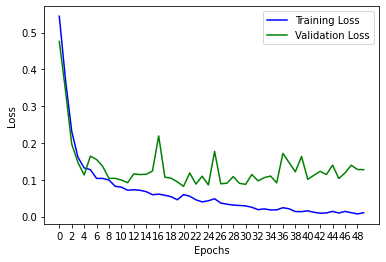

In [73]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

#### Evaluation & Classification report on training set

In [74]:
# Make a set of predictions for the training data
pred_no_weights = model.predict_classes(X_train_data)

# Print performance details
print(metrics.classification_report(y_train_num, pred_no_weights))
print("Confusion matrix")
print(metrics.confusion_matrix(y_train_num, pred_no_weights))

train_acc['LeNet5 Unbalanced'] = metrics.accuracy_score(y_train_num, pred_no_weights)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       908
           1       1.00      0.99      0.99      2754

    accuracy                           0.99      3662
   macro avg       0.98      0.99      0.98      3662
weighted avg       0.99      0.99      0.99      3662

Confusion matrix
[[ 896   12]
 [  34 2720]]


#### Evaluation & Classification report on test set

In [75]:
# Make a set of predictions for the test data
pred_no_weights_test = model.predict_classes(X_test_data)

# Print performance details
print(metrics.classification_report(y_test_num, pred_no_weights_test))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, pred_no_weights_test))

test_acc['LeNet5 Unbalanced'] = metrics.accuracy_score(y_test_num, pred_no_weights_test)

              precision    recall  f1-score   support

           0       0.99      0.38      0.55       234
           1       0.73      1.00      0.84       390

    accuracy                           0.77       624
   macro avg       0.86      0.69      0.70       624
weighted avg       0.83      0.77      0.73       624

Confusion matrix
[[ 90 144]
 [  1 389]]


#### Show correctly classified images

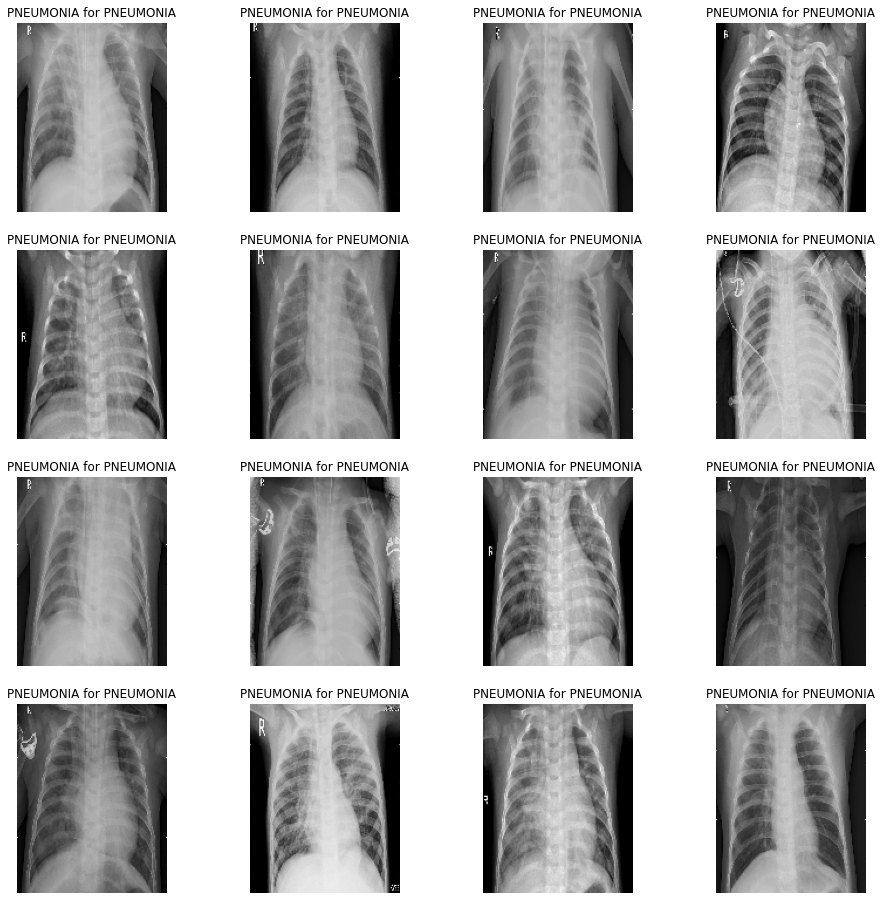

In [76]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = pred_no_weights_test.reshape(-1)
corrects = predictions == y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test_data.shape[0]):
    if ii>=maxtoshow:
        break
    if corrects[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((X_test_data[i] * 255).astype(np.uint8)))
        plt.title("{} for {}".format(classes_num_label[predictions[i]], y_test_data[i]))
        ii = ii + 1

#### Show incorrectly classified images

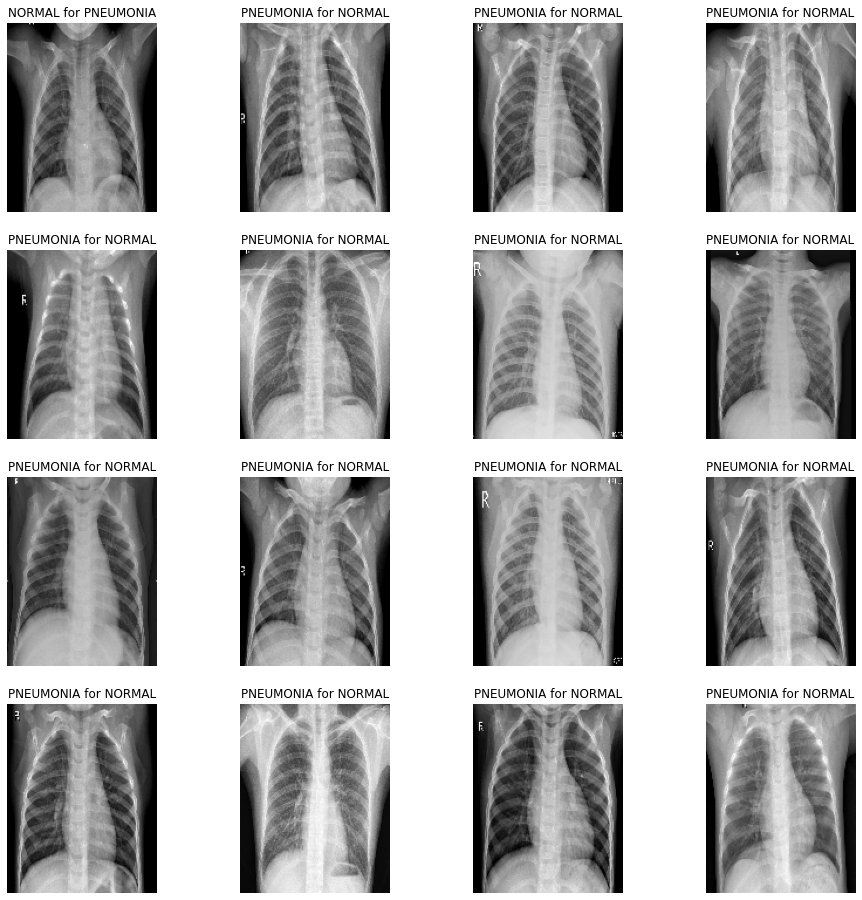

In [77]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = pred_no_weights_test.reshape(-1)
corrects = predictions == y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test_data.shape[0]):
    if ii>=maxtoshow:
        break
    if not corrects[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((X_test_data[i] * 255).astype(np.uint8)))
        plt.title("{} for {}".format(classes_num_label[predictions[i]], y_test_data[i]))
        ii = ii + 1

#### Inference

The standard LeNet-5 architecture was used in building the CNN classifier. The results are better than base model(Logistic Regression). There are still large number of false positives(predicted pneumonia for normal) because there is high bias towards pneumonia patients in the dataset.    

The number of true negatives(predicted normal for normal) is higher than the results in base model which is good.

For regularisation, we introduced a dropout layer to avoid overfitting of data.

The dataset is highly imbalanced and hence we try to solve this issue further in class weights. 

### LeNet 5 - using Class Weights

In [78]:
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(162,128,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(84, activation='relu'))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

optimizer = keras.optimizers.Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 158, 124, 32)      2432      
_________________________________________________________________
activation_17 (Activation)   (None, 158, 124, 32)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 79, 62, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 58, 64)        51264     
_________________________________________________________________
activation_18 (Activation)   (None, 75, 58, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 37, 29, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 68672)            

In [79]:
batch_size = 128
epochs = 50

# Set up the callback to save the best model based on validaion data
best_weights_filepath = './simple_cnn_balanced.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

history = model.fit(X_train_data, y_train_wide, class_weight=class_weights,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_data=(X_val_data, y_val_wide),
          shuffle=True,
          callbacks=[mcp])

#reload best weights
model.load_weights(best_weights_filepath)

Train on 3662 samples, validate on 1570 samples
Epoch 1/50
3662/3662 [==============================] - 7s 2ms/step - loss: 0.5184 - accuracy: 0.7447 - val_loss: 0.4098 - val_accuracy: 0.7210
Epoch 2/50
3662/3662 [==============================] - 7s 2ms/step - loss: 0.3007 - accuracy: 0.8588 - val_loss: 0.2033 - val_accuracy: 0.9268
Epoch 3/50
3662/3662 [==============================] - 7s 2ms/step - loss: 0.1933 - accuracy: 0.9268 - val_loss: 0.1315 - val_accuracy: 0.9497
Epoch 4/50
3662/3662 [==============================] - 7s 2ms/step - loss: 0.1376 - accuracy: 0.9522 - val_loss: 0.1120 - val_accuracy: 0.9599
Epoch 5/50
3662/3662 [==============================] - 7s 2ms/step - loss: 0.1102 - accuracy: 0.9590 - val_loss: 0.1030 - val_accuracy: 0.9637
Epoch 6/50
3662/3662 [==============================] - 7s 2ms/step - loss: 0.1059 - accuracy: 0.9623 - val_loss: 0.1530 - val_accuracy: 0.9484
Epoch 7/50
3662/3662 [==============================] - 7s 2ms/step - loss: 0.1175 - acc

#### Plot training loss vs validation loss

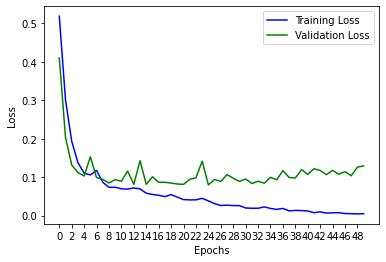

In [80]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

#### Evaluation & Classification report on training set

In [81]:
# Make a set of predictions for the training data
pred_weights = model.predict_classes(X_train_data)

# Print performance details
print(metrics.classification_report(y_train_num, pred_weights))
print("Confusion matrix")
print(metrics.confusion_matrix(y_train_num, pred_weights))

train_acc['LeNet5 Balanced'] = metrics.accuracy_score(y_train_num, pred_weights)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       908
           1       1.00      1.00      1.00      2754

    accuracy                           0.99      3662
   macro avg       0.99      0.99      0.99      3662
weighted avg       0.99      0.99      0.99      3662

Confusion matrix
[[ 901    7]
 [  13 2741]]


#### Evaluation & Classification report on test set

In [82]:
# Make a set of predictions for the test data
pred_weights_test = model.predict_classes(X_test_data)

# Print performance details
print(metrics.classification_report(y_test_num, pred_weights_test))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, pred_weights_test))

test_acc['LeNet5 Balanced'] = metrics.accuracy_score(y_test_num, pred_weights_test)

              precision    recall  f1-score   support

           0       0.97      0.38      0.55       234
           1       0.73      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.85      0.69      0.69       624
weighted avg       0.82      0.76      0.73       624

Confusion matrix
[[ 89 145]
 [  3 387]]


In [31]:
display(X_train_data.shape)
display(X_val_data.shape)

(3662, 162, 128, 3)

(1570, 162, 128, 3)

#### Show correctly classified images

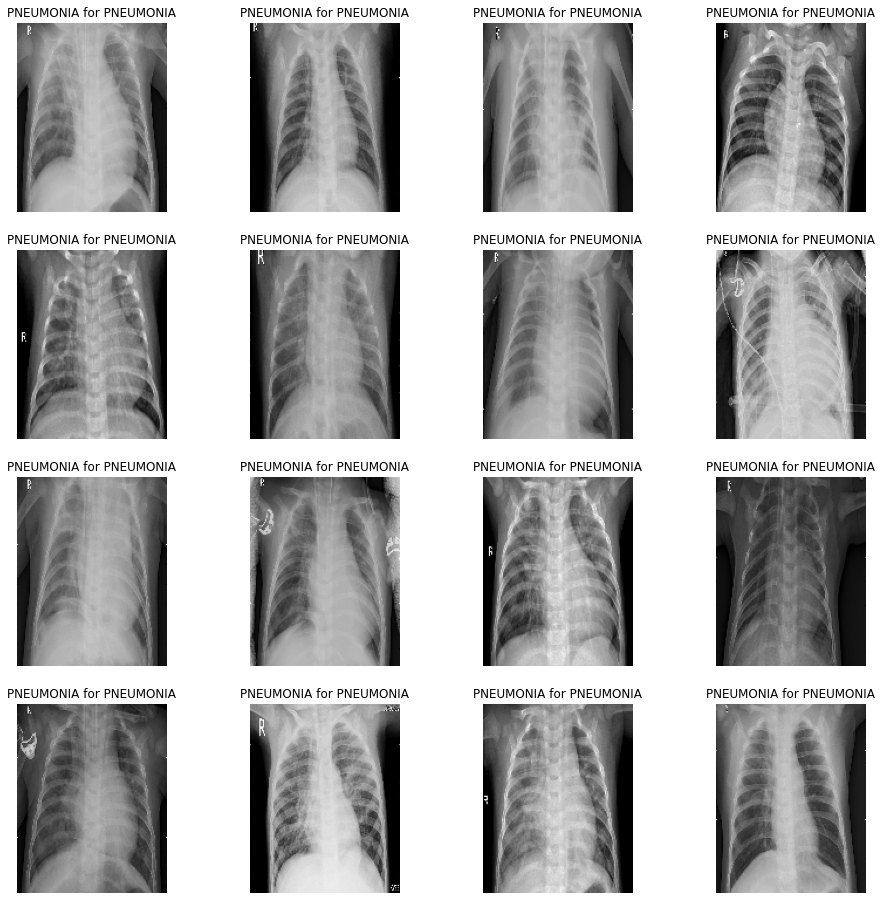

In [33]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = pred_weights_test.reshape(-1)
corrects = predictions == y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test_data.shape[0]):
    if ii>=maxtoshow:
        break
    if corrects[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((X_test_data[i] * 255).astype(np.uint8)))
        plt.title("{} for {}".format(classes_num_label[predictions[i]], y_test_data[i]))
        ii = ii + 1

#### Show incorrectly classified images

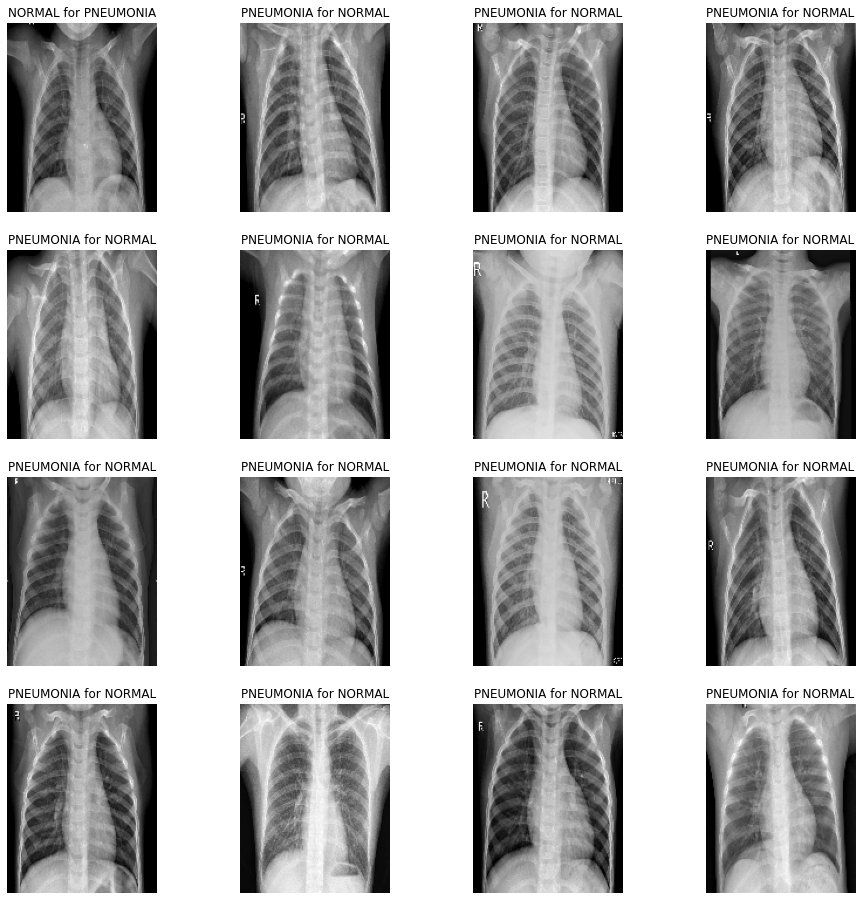

In [34]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = pred_weights_test.reshape(-1)
corrects = predictions == y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test_data.shape[0]):
    if ii>=maxtoshow:
        break
    if not corrects[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((X_test_data[i] * 255).astype(np.uint8)))
        plt.title("{} for {}".format(classes_num_label[predictions[i]], y_test_data[i]))
        ii = ii + 1

#### Inference

The results show that there is not much of improvement after introducing class weights. However, even if we there were much of an effect, it would be counter-intuitive to our needs since we it is more important to detect pneumonia rather than lack of pneumonia. Hence, the bias in dataset is justified.

## Task 4: LeNet5 with Data Augmentation

### Augmentation samples

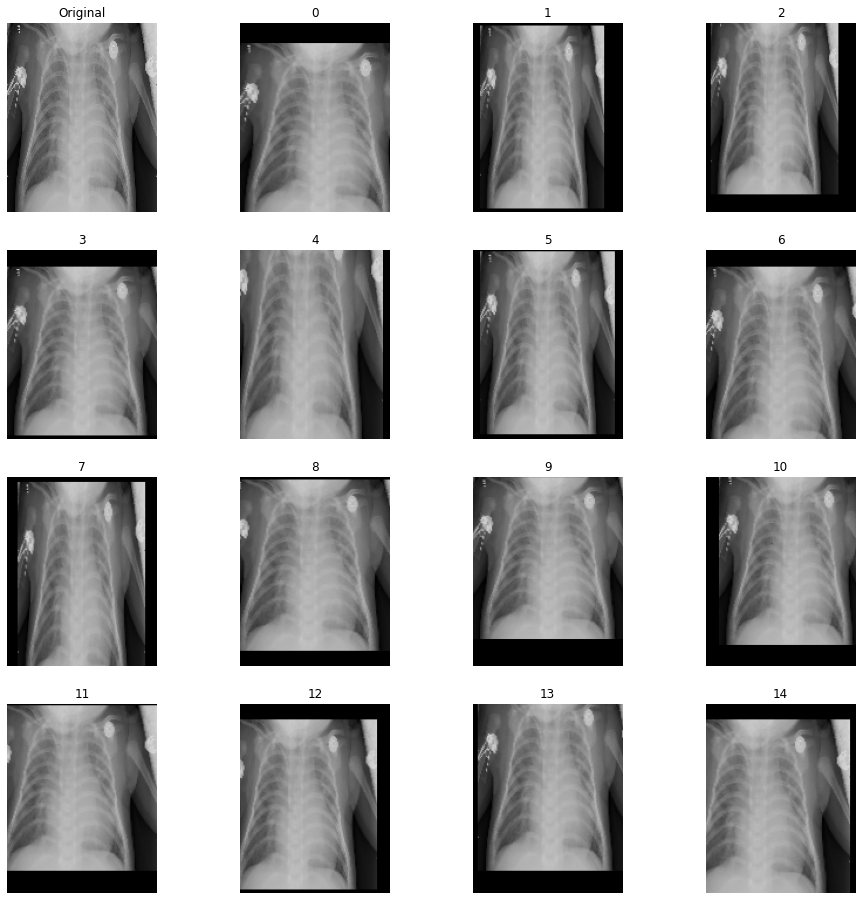

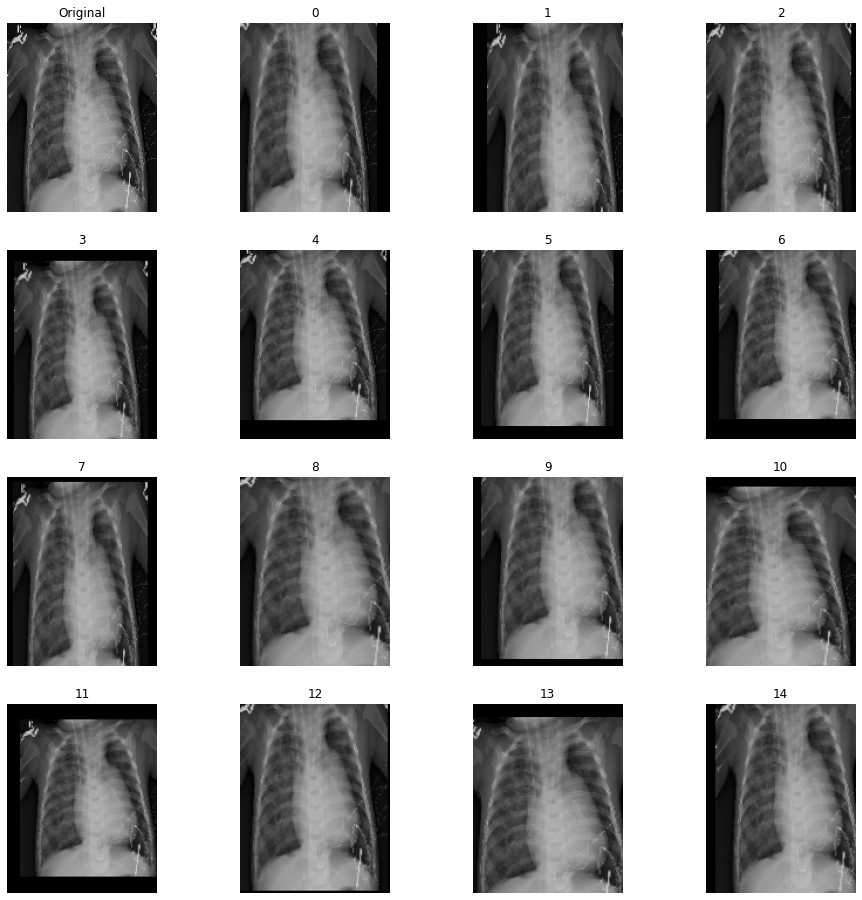

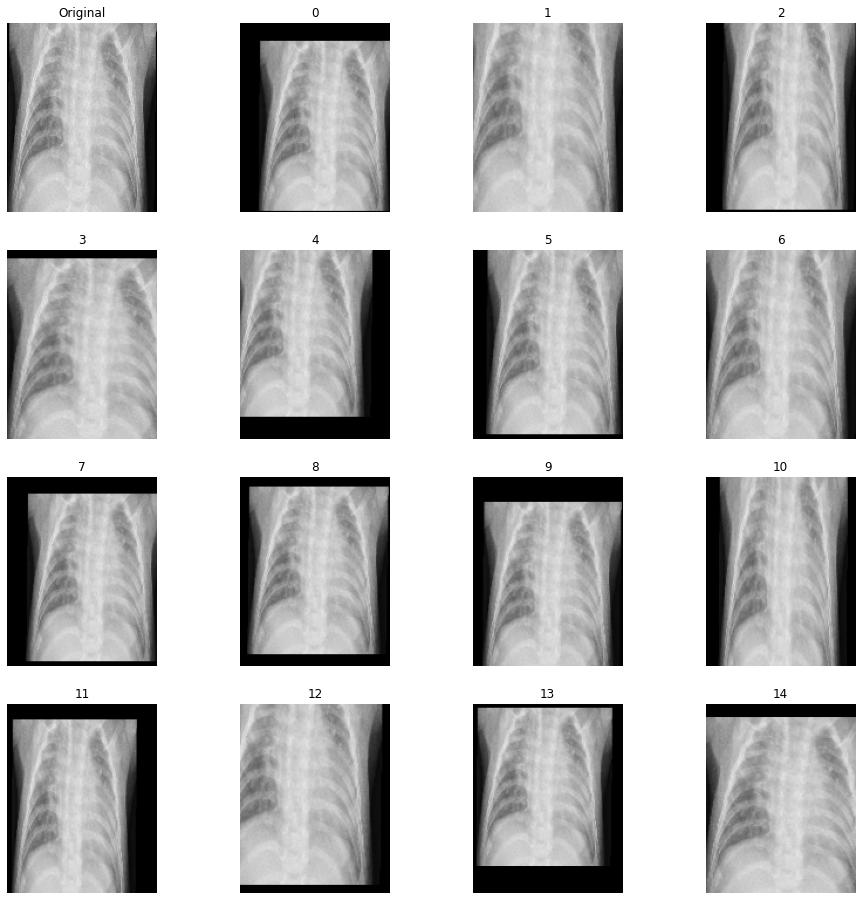

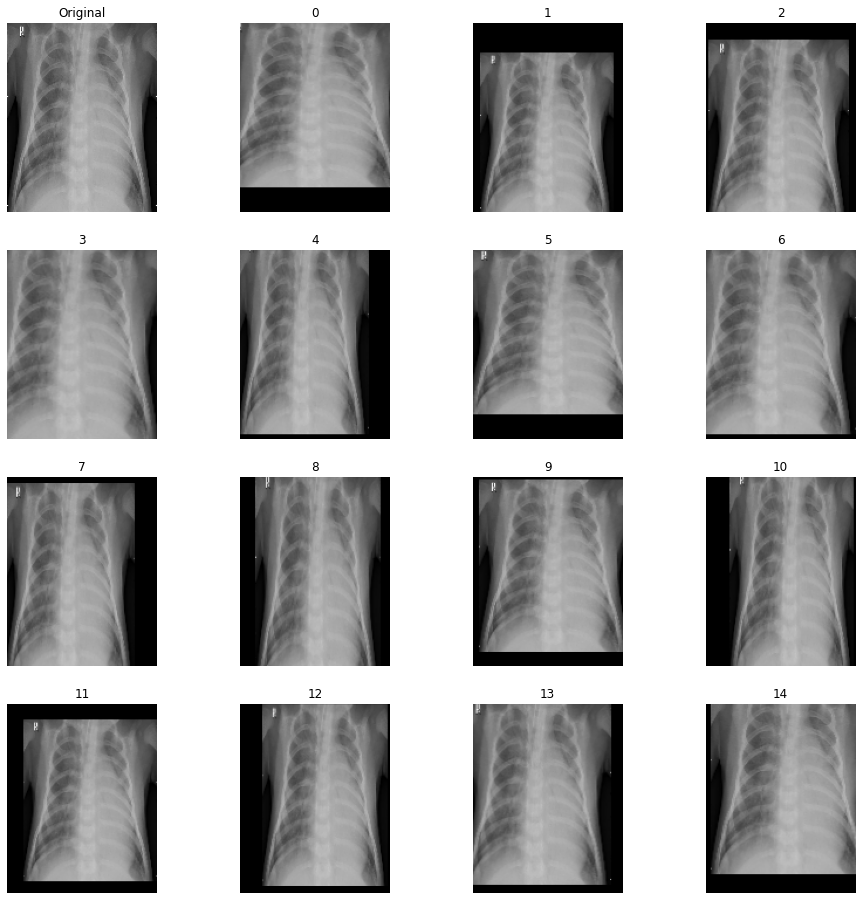

In [83]:
pltsize=4
row_images = 4
col_images = 4

# Create a transformed data generator
datagen = ImageDataGenerator(
    featurewise_center=True,
    width_shift_range=0.1,
    height_shift_range=0.1, fill_mode='constant', cval = 0 ,zoom_range=[0.8,1.2])

# fit parameters from data
datagen.fit(X_train)

for idx in range(0, 4):
    # Plot the original image
    plt.figure(figsize=(col_images*pltsize, row_images*pltsize))
    plt.subplot(row_images,col_images,1)
    plt.axis('off')
    plt.imshow(PIL.Image.fromarray((X_train[idx] * 255).astype(np.uint8)))

    plt.title("Original")

    for i in range(row_images * col_images - 1):
        rand_trans = datagen.random_transform(X_train[idx])
        plt.subplot(row_images,col_images,i+2)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((rand_trans * 255).astype(np.uint8)))
        plt.title(i)

    plt.show()                             

### CNN Model with Data Augmentation

In [36]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(162,128,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(84, activation='relu'))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

optimizer = keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 160, 126, 32)      896       
_________________________________________________________________
activation_9 (Activation)    (None, 160, 126, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 80, 63, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 78, 61, 64)        18496     
_________________________________________________________________
activation_10 (Activation)   (None, 78, 61, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 39, 30, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 74880)            

In [37]:
batch_size = 128
epochs = 20

# Set up the callback to save the best model based on validaion data
best_weights_filepath = './data_augmentation.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

# Create a data generator for the trianing data
datagen_train = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,zoom_range=[0.8,1.2], fill_mode='constant', cval = 0)

datagen_train.fit(X_train)
        
history = model.fit_generator(datagen_train.flow(X_train_data, y_train_wide, batch_size=batch_size),
          validation_data = (X_val_data, y_val_wide),
          epochs=epochs,
          verbose = 1,
          shuffle=True,
          callbacks=[mcp])

#reload best weights
model.load_weights(best_weights_filepath)

Epoch 1/20
29/29 [==============================] - 16s 561ms/step - loss: 0.6429 - accuracy: 0.7343 - val_loss: 0.6097 - val_accuracy: 0.7191
Epoch 2/20
29/29 [==============================] - 15s 511ms/step - loss: 0.5632 - accuracy: 0.7520 - val_loss: 0.5501 - val_accuracy: 0.7191
Epoch 3/20
29/29 [==============================] - 15s 518ms/step - loss: 0.5039 - accuracy: 0.7520 - val_loss: 0.4252 - val_accuracy: 0.7191
Epoch 4/20
29/29 [==============================] - 15s 519ms/step - loss: 0.4661 - accuracy: 0.7523 - val_loss: 0.4042 - val_accuracy: 0.7191
Epoch 5/20
29/29 [==============================] - 15s 516ms/step - loss: 0.4384 - accuracy: 0.7534 - val_loss: 0.3359 - val_accuracy: 0.7191
Epoch 6/20
29/29 [==============================] - 15s 524ms/step - loss: 0.3845 - accuracy: 0.7589 - val_loss: 0.4072 - val_accuracy: 0.7930
Epoch 7/20
29/29 [==============================] - 15s 513ms/step - loss: 0.3902 - accuracy: 0.7889 - val_loss: 0.2942 - val_accuracy: 0.9045

### Plot training loss vs validation loss

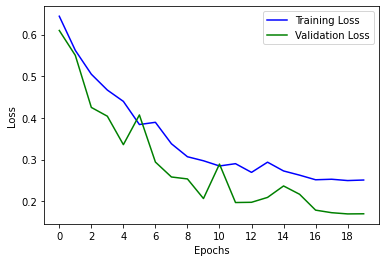

In [38]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

### Evaluation & Classification report on training set

In [39]:
# Make a set of predictions for the training data
pred_aug = model.predict_classes(X_train_data)

# Print performance details
print(metrics.classification_report(y_train_num, pred_aug))
print("Confusion matrix")
print(metrics.confusion_matrix(y_train_num, pred_aug))

train_acc['CNN Augmentation'] = metrics.accuracy_score(y_train_num, pred_aug)

              precision    recall  f1-score   support

           0       0.82      0.94      0.88       908
           1       0.98      0.93      0.95      2754

    accuracy                           0.93      3662
   macro avg       0.90      0.94      0.92      3662
weighted avg       0.94      0.93      0.93      3662

Confusion matrix
[[ 858   50]
 [ 194 2560]]


### Evaluation & Classification report on test set

In [40]:
# Make a set of predictions for the test data
pred_aug_test = model.predict_classes(X_test_data)

# Print performance details
print(metrics.classification_report(y_test_num, pred_aug_test))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, pred_aug_test))

test_acc['CNN Augmentation'] = metrics.accuracy_score(y_test_num, pred_aug_test)

              precision    recall  f1-score   support

           0       0.93      0.70      0.80       234
           1       0.84      0.97      0.90       390

    accuracy                           0.87       624
   macro avg       0.88      0.83      0.85       624
weighted avg       0.87      0.87      0.86       624

Confusion matrix
[[164  70]
 [ 13 377]]


### Show correctly classified images

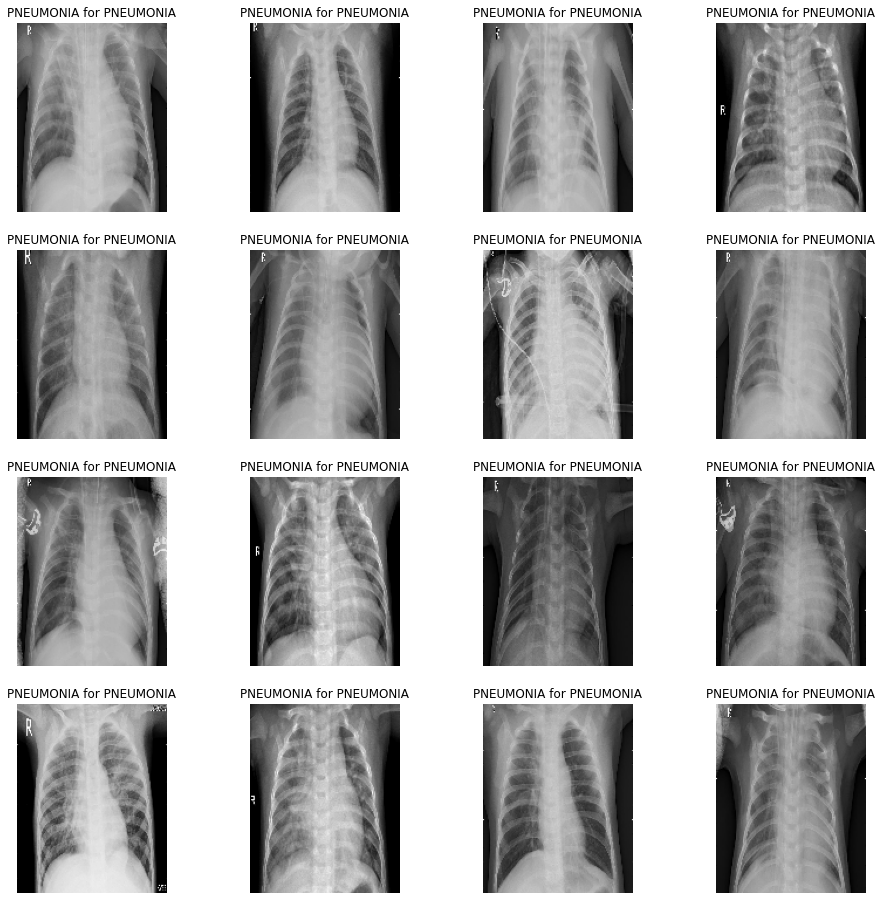

In [41]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = pred_aug_test.reshape(-1)
corrects = predictions == y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test_data.shape[0]):
    if ii>=maxtoshow:
        break
    if corrects[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((X_test_data[i] * 255).astype(np.uint8)))
        plt.title("{} for {}".format(classes_num_label[predictions[i]], y_test_data[i]))
        ii = ii + 1

### Show incorrectly classified images

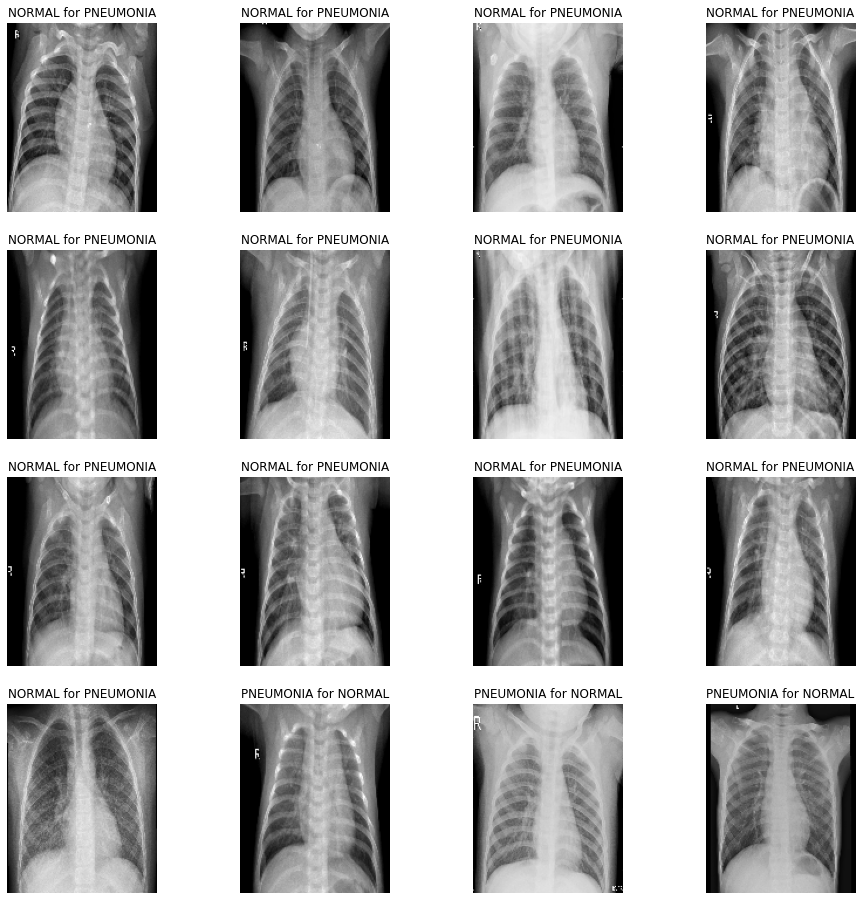

In [42]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = pred_aug_test.reshape(-1)
corrects = predictions == y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test_data.shape[0]):
    if ii>=maxtoshow:
        break
    if not corrects[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((X_test_data[i] * 255).astype(np.uint8)))
        plt.title("{} for {}".format(classes_num_label[predictions[i]], y_test_data[i]))
        ii = ii + 1

### Inference
For image augmentation, we used `height_shift_range`, `width_shift_range`, `zoom_range` and `fill_mode` as parameters. For shifted and zoomed images, we decided to give a constant background of 0(black) using fill_mode.

We tried using `zca_whitening` and `brightness_range` as parameters but the model only predicted single class using them.

The results on test set after data augmentation are significantly better than previous models. This might be because the model was trained on more training data due to data augmentation.

## Task 5: CNN with VGG-16

### Simple VGG-16

In [43]:
vgg16_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = X_train[0].shape)
display(vgg16_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 162, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 162, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 162, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 81, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 81, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 81, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 32, 128)       0     

None

In [45]:
vgg16_last_layer = vgg16_model.output

# build a classifier model to put on top of the VGG16 model
x1 = Flatten()(vgg16_last_layer)
x2 = Dense(256, activation='relu')(x1)
x3 = Dropout(0.5)(x2)
final_layer = Dense(num_classes, activation = 'softmax')(x3)

# Assemble the full model out of both parts
full_model = keras.Model(vgg16_model.input, final_layer)

# set the first 17 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in full_model.layers[:17]:
    layer.trainable = False

# compile the model with a Adam optimizer
# and a very slow learning rate.
full_model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

full_model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 162, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 162, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 162, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 81, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 81, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 81, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 32, 128)       0   

In [46]:
batch_size = 128
epochs = 20

# Set up the callback to save the best model based on validaion data - notebook 2.2 needs to be run first.
best_weights_filepath = './vgg16_freeze17.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

history = full_model.fit(X_train_data, y_train_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_data = (X_val_data,y_val_wide),
          shuffle=True,
          callbacks=[mcp])

#reload best weights
full_model.load_weights(best_weights_filepath)

Train on 3662 samples, validate on 1570 samples
Epoch 1/20
3662/3662 [==============================] - 29s 8ms/step - loss: 0.5442 - accuracy: 0.8629 - val_loss: 0.1106 - val_accuracy: 0.9605
Epoch 2/20
3662/3662 [==============================] - 20s 5ms/step - loss: 0.0808 - accuracy: 0.9721 - val_loss: 0.0601 - val_accuracy: 0.9790
Epoch 3/20
3662/3662 [==============================] - 20s 5ms/step - loss: 0.0546 - accuracy: 0.9792 - val_loss: 0.0749 - val_accuracy: 0.9732
Epoch 4/20
3662/3662 [==============================] - 20s 5ms/step - loss: 0.0411 - accuracy: 0.9866 - val_loss: 0.0586 - val_accuracy: 0.9758
Epoch 5/20
3662/3662 [==============================] - 20s 5ms/step - loss: 0.0316 - accuracy: 0.9885 - val_loss: 0.0748 - val_accuracy: 0.9726
Epoch 6/20
3662/3662 [==============================] - 20s 5ms/step - loss: 0.0289 - accuracy: 0.9883 - val_loss: 0.0536 - val_accuracy: 0.9822
Epoch 7/20
3662/3662 [==============================] - 20s 5ms/step - loss: 0.016

#### Plot training loss vs validation loss

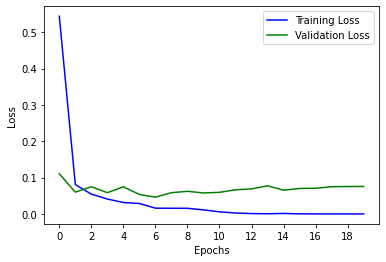

In [47]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

#### Evaluation & Classification report on training set

In [48]:
pred_vgg = np.argmax(full_model.predict(X_train_data),axis=1)

# Print performance details
print(metrics.classification_report(y_train_num, pred_vgg))
print("Confusion matrix")
print(metrics.confusion_matrix(y_train_num, pred_vgg))

train_acc['CNN VGG-16'] = metrics.accuracy_score(y_train_num, pred_vgg)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       908
           1       1.00      1.00      1.00      2754

    accuracy                           1.00      3662
   macro avg       1.00      1.00      1.00      3662
weighted avg       1.00      1.00      1.00      3662

Confusion matrix
[[ 906    2]
 [   1 2753]]


#### Evaluation & Classification report on test set

In [49]:
pred_vgg_test = np.argmax(full_model.predict(X_test_data),axis=1)

# Print performance details
print(metrics.classification_report(y_test_num, pred_vgg_test))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, pred_vgg_test))

test_acc['CNN VGG-16'] = metrics.accuracy_score(y_test_num, pred_vgg_test)

              precision    recall  f1-score   support

           0       0.99      0.39      0.56       234
           1       0.73      1.00      0.84       390

    accuracy                           0.77       624
   macro avg       0.86      0.70      0.70       624
weighted avg       0.83      0.77      0.74       624

Confusion matrix
[[ 92 142]
 [  1 389]]


#### Show correctly classified images

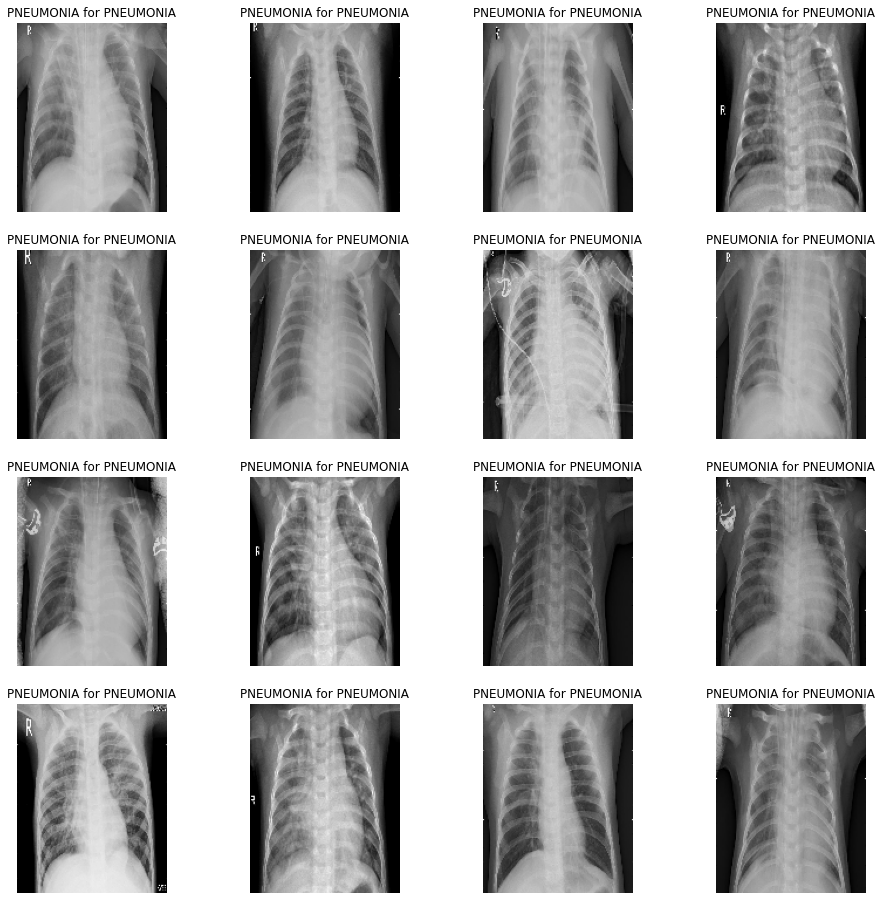

In [52]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = pred_vgg_test.reshape(-1)
corrects = predictions == y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test_data.shape[0]):
    if ii>=maxtoshow:
        break
    if corrects[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((X_test_data[i] * 255).astype(np.uint8)))
        plt.title("{} for {}".format(classes_num_label[predictions[i]], y_test_data[i]))
        ii = ii + 1

#### Show incorrectly classified images

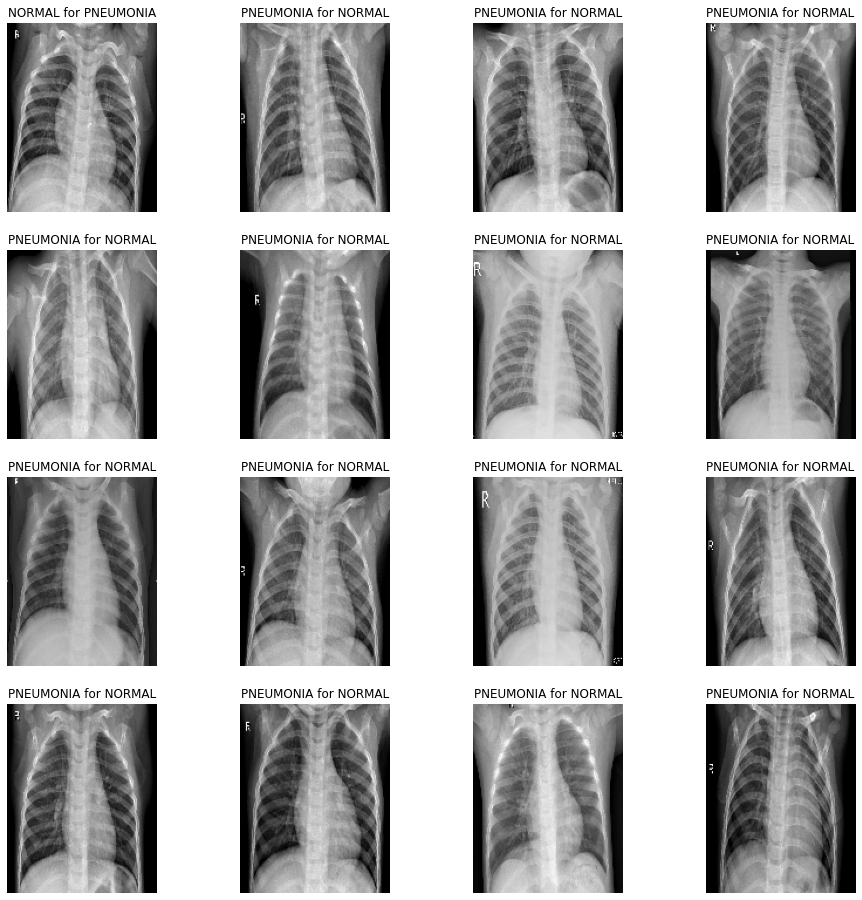

In [53]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = pred_vgg_test.reshape(-1)
corrects = predictions == y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test_data.shape[0]):
    if ii>=maxtoshow:
        break
    if not corrects[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((X_test_data[i] * 255).astype(np.uint8)))
        plt.title("{} for {}".format(classes_num_label[predictions[i]], y_test_data[i]))
        ii = ii + 1

#### Inference

VGG-16 pre-trained model was used and we freezed weights for the top 17 layers.
The last convolution layer was trainable. Transfer learning did not have any major impact as compared to simple LeNet-5 architecture.

We tried unfreezing couple more convolution layers, but that did not have enough effect.

### VGG-16 with data augmentation

In [54]:
vgg16_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = X_train[0].shape)
display(vgg16_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 162, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 162, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 162, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 81, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 81, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 81, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 32, 128)       0     

None

In [55]:
vgg16_last_layer = vgg16_model.output

# build a classifier model to put on top of the VGG16 model
x1 = Flatten()(vgg16_last_layer)
x2 = Dense(256, activation='relu')(x1)
x3 = Dropout(0.5)(x2)
final_layer = Dense(num_classes, activation = 'softmax')(x3)

# Assemble the full model out of both parts
full_model = keras.Model(vgg16_model.input, final_layer)

# set the first 17 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in full_model.layers[:17]:
    layer.trainable = False

# compile the model with a Adam optimizer
# and a very slow learning rate.
full_model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

full_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 162, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 162, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 162, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 81, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 81, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 81, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 32, 128)       0   

In [56]:
batch_size = 128
epochs = 20

# Set up the callback to save the best model based on validaion data - notebook 2.2 needs to be run first.
best_weights_filepath = './vgg16_freeze17_augmentation.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

# Create a data generator for the trianing data
datagen_train = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,zoom_range=[0.8,1.2], fill_mode='constant', cval = 0)

datagen_train.fit(X_train)
        
history = full_model.fit_generator(datagen_train.flow(X_train_data, y_train_wide, batch_size=batch_size),
          epochs=epochs,
          verbose = 1,
          validation_data = (X_val_data,y_val_wide),
          shuffle=True,
          callbacks=[mcp])

#reload best weights
full_model.load_weights(best_weights_filepath)

Epoch 1/20
29/29 [==============================] - 23s 778ms/step - loss: 0.5903 - accuracy: 0.8282 - val_loss: 0.2225 - val_accuracy: 0.9159
Epoch 2/20
29/29 [==============================] - 19s 650ms/step - loss: 0.1547 - accuracy: 0.9443 - val_loss: 0.1505 - val_accuracy: 0.9401
Epoch 3/20
29/29 [==============================] - 19s 653ms/step - loss: 0.1272 - accuracy: 0.9533 - val_loss: 0.1487 - val_accuracy: 0.9446
Epoch 4/20
29/29 [==============================] - 19s 653ms/step - loss: 0.1291 - accuracy: 0.9536 - val_loss: 0.4132 - val_accuracy: 0.8548
Epoch 5/20
29/29 [==============================] - 19s 655ms/step - loss: 0.1457 - accuracy: 0.9481 - val_loss: 0.2676 - val_accuracy: 0.8943
Epoch 6/20
29/29 [==============================] - 19s 655ms/step - loss: 0.1090 - accuracy: 0.9593 - val_loss: 0.1211 - val_accuracy: 0.9548
Epoch 7/20
29/29 [==============================] - 20s 696ms/step - loss: 0.1013 - accuracy: 0.9631 - val_loss: 0.2710 - val_accuracy: 0.9025

#### Plot training loss vs validation loss

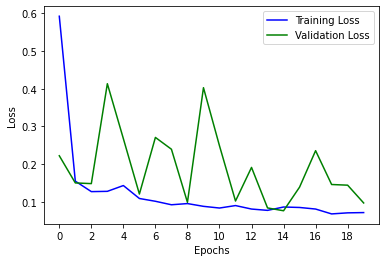

In [57]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

#### Evaluation & Classification report on training set

In [58]:
pred_vgg_aug = np.argmax(full_model.predict(X_train_data),axis=1)

# Print performance details
print(metrics.classification_report(y_train_num, pred_vgg_aug))
print("Confusion matrix")
print(metrics.confusion_matrix(y_train_num, pred_vgg_aug))

train_acc['CNN VGG-16 aug'] = metrics.accuracy_score(y_train_num, pred_vgg_aug)

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       908
           1       0.99      0.97      0.98      2754

    accuracy                           0.98      3662
   macro avg       0.96      0.98      0.97      3662
weighted avg       0.98      0.98      0.98      3662

Confusion matrix
[[ 886   22]
 [  69 2685]]


#### Evaluation & Classification report on test set

In [59]:
pred_vgg_aug_test = np.argmax(full_model.predict(X_test_data),axis=1)

# Print performance details
print(metrics.classification_report(y_test_num, pred_vgg_aug_test))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, pred_vgg_aug_test))

test_acc['CNN VGG-16 aug'] = metrics.accuracy_score(y_test_num, pred_vgg_aug_test)

              precision    recall  f1-score   support

           0       0.98      0.73      0.84       234
           1       0.86      0.99      0.92       390

    accuracy                           0.89       624
   macro avg       0.92      0.86      0.88       624
weighted avg       0.90      0.89      0.89       624

Confusion matrix
[[170  64]
 [  3 387]]


#### Show correctly classified images

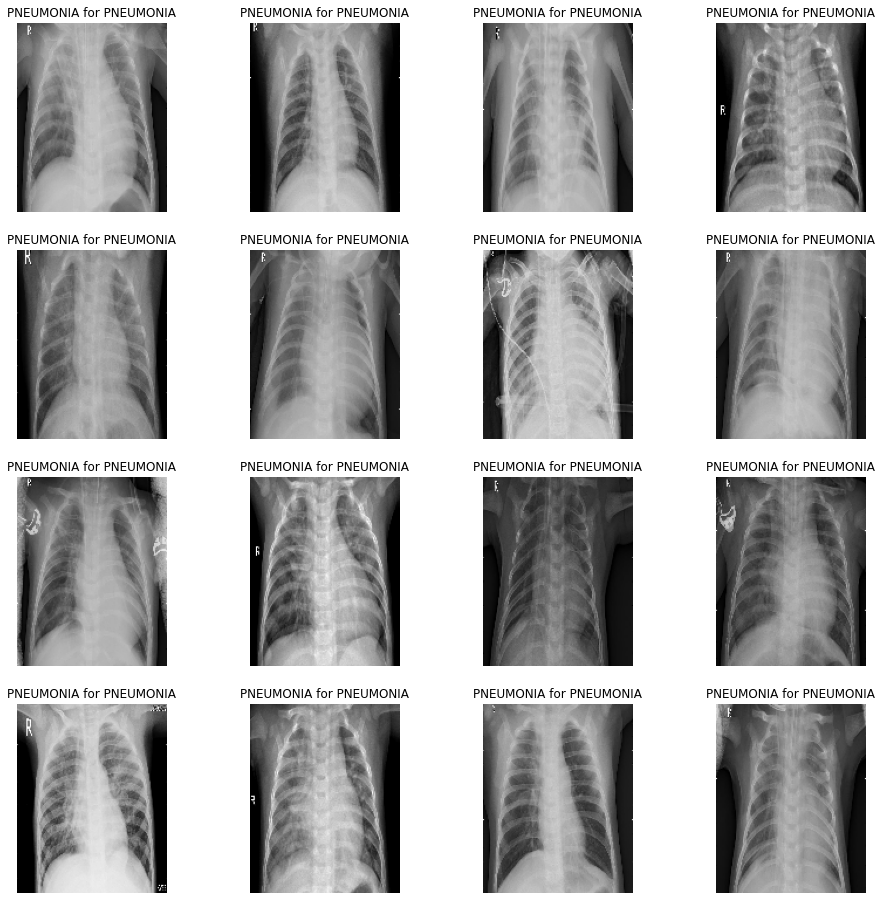

In [60]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = pred_vgg_aug_test.reshape(-1)
corrects = predictions == y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test_data.shape[0]):
    if ii>=maxtoshow:
        break
    if corrects[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((X_test_data[i] * 255).astype(np.uint8)))
        plt.title("{} for {}".format(classes_num_label[predictions[i]], y_test_data[i]))
        ii = ii + 1

#### Show incorrectly classified images

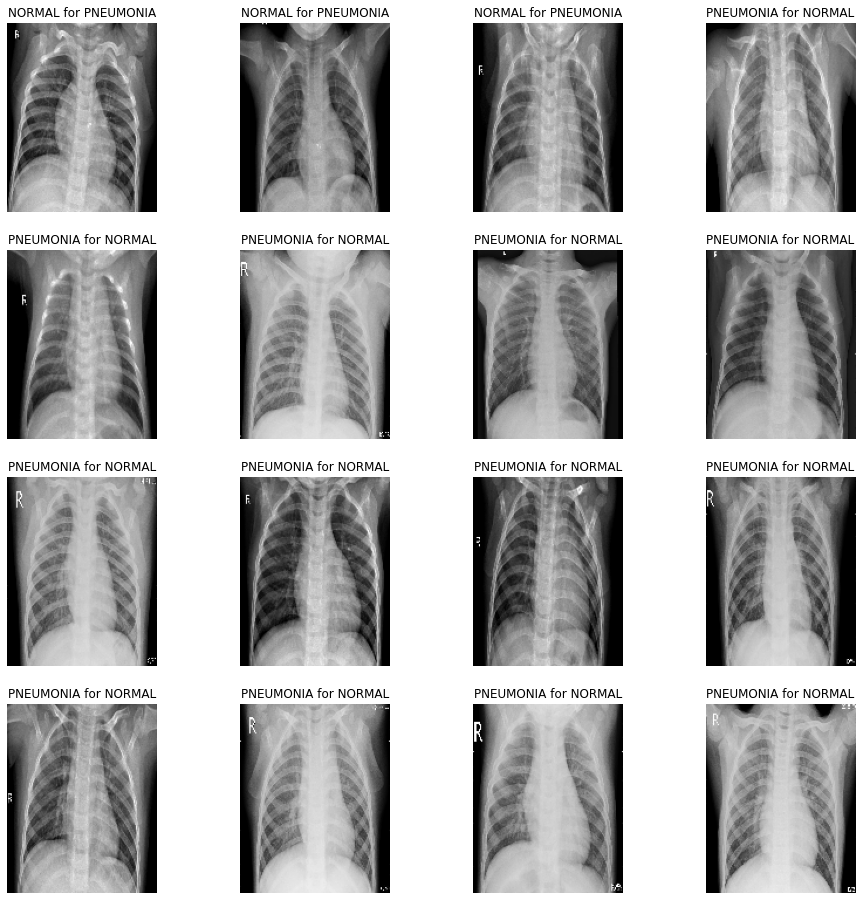

In [61]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = pred_vgg_aug_test.reshape(-1)
corrects = predictions == y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test_data.shape[0]):
    if ii>=maxtoshow:
        break
    if not corrects[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((X_test_data[i] * 255).astype(np.uint8)))
        plt.title("{} for {}".format(classes_num_label[predictions[i]], y_test_data[i]))
        ii = ii + 1

#### Inference

Again, the results using data augmentation were better because more images were present in the train set.

## Task 6: Performance comparison accross all the models

Model  Accuracy
0  Logistic Regression  1.000000
1    LeNet5 Unbalanced  0.987439
2      LeNet5 Balanced  0.994539
3     CNN Augmentation  0.933370
4           CNN VGG-16  0.999181
5       CNN VGG-16 aug  0.975150

(0.6, 1.05)

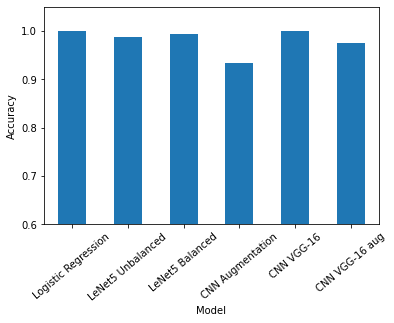

In [84]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

traindf = pd.DataFrame(train_acc.items(), columns=['Model', 'Accuracy'])
display(traindf)
print("\n\n")
traindf.plot.bar(x = 'Model', y = 'Accuracy', ax = ax, legend = False, rot = '40')
plt.ylabel('Accuracy')
plt.ylim(ymin=0.6)  # this line

Model  Accuracy
0  Logistic Regression  0.741987
1    LeNet5 Unbalanced  0.767628
2      LeNet5 Balanced  0.762821
3     CNN Augmentation  0.866987
4           CNN VGG-16  0.770833
5       CNN VGG-16 aug  0.892628

(0.6, 0.9372596153846154)

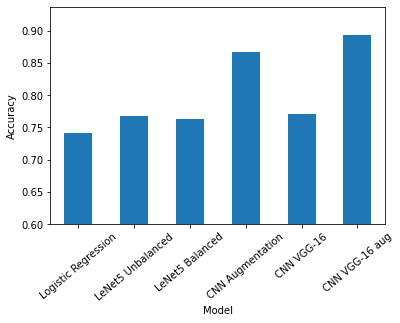

In [85]:
testdf = pd.DataFrame(test_acc.items(), columns=['Model', 'Accuracy'])
display(testdf)
print()

fig, ax = plt.subplots()
testdf.plot(kind='bar', x = 'Model', y = 'Accuracy', ax = ax, legend = False, rot = '40')
plt.ylabel('Accuracy')
plt.ylim(ymin=0.6)  # this line

## Task 7: Conclusion

1. **Logistic regression** model doesn't work as good as neural network models on image dataset. Neural networks are designed to self-learn features from images whereas for logistic regression, feature engineering has to be performed separately.

2. Handling **class imbalance** using class weights **didn't have any significant impact** on the results of LeNet5 CNN architecture.   
Since the bias is towards Pneumonia, if we attempt to balance dataset, the bias would ideally be introduced towards normal classes. **But detecting Pneumonia correctly is more important that detecting lack of pneumonia**. Hence, for further processing we chose not to rectify class imbalance.  

3. **Models incorporating data augmentation technique work better than their base models**. (This can be inferred from the bar plot that summarizes test accuracies of all the models)

4. Using **transfer learning** with pre-trained models is **faster** than training a full model from scratch while giving similar results.

5. In terms of accuracies -  
    **VGG16 with Augmentation > LeNet5 with Augmentation > Vgg16 > LeNet5**

**Interesting behavior -**
1.  In LeNet5 data augmentation models, we see that throughout training process, **validation loss is consistently lower than training loss**. This could be because of number of reasons -
    * Excessive data augmentation (This can cause training accuracy to appear low while in fact the model is still learning)
    *  Regularisation such as dropout are turned off at testing time.
    * Test loss is computed using model as it is at the end of epoch. As the model is changing ove time, training loss in first batch of epoch is higher than over last batches. Hence, the overall average training loss can be greater than validation loss.   
    (FAQ - Keras Documentation, 2020) (error, Mudau and Beker, 2020)

2. The validation loss is **highly volatile** in Vgg16 with data augmentation which seems strange. This could be because of number of factors namely regularisation or learning rate.

References - 
* Keras.io. 2020. FAQ - Keras Documentation. [online] Available at: <https://keras.io/getting-started/faq/#why-is-the-training-loss-much-higher-than-the-testing-loss> [Accessed 1 May 2020].

* W., Mudau, T. and Beker, D., 2020. Why My Test Error Is Lower Then Train Error. [online] Artificial Intelligence Stack Exchange. Available at: <https://ai.stackexchange.com/questions/4385/why-my-test-error-is-lower-then-train-error/4413#4413> [Accessed 1 May 2020].